### refs usadas:
- https://www.researchgate.net/publication/324929106_Dynamic_Models_of_a_Home_Refrigerator
- http://www.ingaero.uniroma1.it/attachments/2176_Cap_3%20Thermal-electrical%20analogy.pdf
- https://www.engineeringtoolbox.com/heat-work-energy-d_292.html
- https://economizandoenergia.wordpress.com/2011/12/11/hackeando-a-geladeira/

### refs não usadas, mas interessantes:
- https://www.researchgate.net/publication/269930557_Temperature_control_in_a_cavity_of_refrigeration_using_PI_controller_and_predictive_control
- http://greenteapress.com/modsimpy/ModSimPy3.pdf


#### Breve revisão de calor no ponto de vista energético:
- Para aquecer um corpo de massa $m$ de calor específico $c_p$ em diferença de temperatura $dT$ é necessário o calor $Q$ (em _Joules_), de modo que:
$$ Q = c_p\,m\,dT $$
- A potência (em _Watts_) necessária para aquecer o mesmo corpo em um intervalo de tempo $t$ é:
$$ q = Q / t $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_freezer_unit(sensor_id: int, verbose=False):
    """ consumo médio de um congelador:
    ref:  http://www.procelinfo.com.br/services/DocumentManagement/FileDownload.EZTSvc.asp?DocumentID={8898769E-E9B6-4AB9-A509-CCAFE715310F}&ServiceInstUID={46764F02-4164-4748-9A41-C8E7309F80E1}
    modelo: RCFB32
    compartimento: 385 Litros
    consumo: 35.9 kwh/mês

    ref:  https://www.mideastore.com.br/media/productattach/m/a/manual_do_usu_rio_3.pdf
    Corrente nominal de operação em 220V: 1.6A
    
    # Parece ok, resultados proximos de: https://economizandoenergia.wordpress.com/tag/freezer/
    """
    E_monthly = 35.9e3 * (0.95 + 0.05 * np.random.rand()) # adicionando uma variação para as unidades
    E_anualy = E_monthly * 12
    hours_per_year = 8760
    E_hourly = E_anualy / hours_per_year
    E_daily = E_hourly * 24
    E_minutely = E_hourly / 60
    E_secondly = E_minutely / 60
    # print(E_anualy, E_monthly, E_daily, E_hourly, E_minutely, E_secondly)

    # Estimativas para fechar com os dados de catálogo:
    I_nominal = 1.6 # corrente indicada pelo catálogo
    P_nominal = 220 * I_nominal
    P_nominal_avg = 250 * (0.8 + 0.2 * np.random.rand()) # adicionando uma variação para as unidades
    on_to_off_factor = P_nominal_avg / P_nominal
    P_on = 220 * I_nominal * on_to_off_factor 
    P_off = 220 * I_nominal * (1 - on_to_off_factor)
    if verbose:
        print(f"P nominal = {P_nominal} W")
        print(f"Pon = {P_on} W")
        print(f"Poff = {P_off} W")
        print(f"Check: {P_nominal == P_on + P_off}")

    t_daily = 24.0
    P_daily = E_daily / t_daily
    t_on = t_daily * (P_daily - P_off) / (P_off - P_on)
    t_off = t_daily - t_on
    duty_cycle = t_on / t_daily
    if verbose:
        print(f"daily total: P = {P_daily} W, t = {t_daily} h")
        print(f"daily on: P = {P_on} W, t = {t_on} h")
        print(f"daily off: P = {P_off} W, t = {t_off} h")
        print(f"duty cycle: {duty_cycle * 100} %")
        print(f"Check: {t_daily == t_on + t_off}")
        
    return {
        'sensor_id': sensor_id,
        'model': 'RCFB32',
        'volume': 385,
        'E_monthly': E_monthly,
        'E_anualy': E_anualy,
        'E_hourly': E_hourly,
        'E_daily': E_daily,
        'E_minutely': E_minutely,
        'E_secondly': E_secondly,
        'I_nominal': I_nominal,
        'P_nominal': P_nominal,
        'P_nominal_avg': P_nominal_avg,
        'on_to_off_factor': on_to_off_factor,
        'P_on': P_on,
        'P_off': P_off,
        't_daily': t_daily,
        'P_daily': P_daily,
        't_on': t_on,
        't_off': t_off,
        'duty_cycle': duty_cycle,
    }

print("EXAMPLE:\n")
example = generate_freezer_unit(0,verbose=True)
display(example)

EXAMPLE:

P nominal = 352.0 W
Pon = 249.18211644516128 W
Poff = 102.81788355483872 W
Check: True
daily total: P = 48.80397448971996 W, t = 24.0 h
daily on: P = 249.18211644516128 W, t = 8.856903028585217 h
daily off: P = 102.81788355483872 W, t = 15.143096971414783 h
duty cycle: 36.903762619105066 %
Check: True


{'sensor_id': 0,
 'model': 'RCFB32',
 'volume': 385,
 'E_monthly': 35626.901377495575,
 'E_anualy': 427522.81652994687,
 'E_hourly': 48.80397448971996,
 'E_daily': 1171.295387753279,
 'E_minutely': 0.8133995748286661,
 'E_secondly': 0.013556659580477769,
 'I_nominal': 1.6,
 'P_nominal': 352.0,
 'P_nominal_avg': 249.18211644516128,
 'on_to_off_factor': 0.7079037399010264,
 'P_on': 249.18211644516128,
 'P_off': 102.81788355483872,
 't_daily': 24.0,
 'P_daily': 48.80397448971996,
 't_on': 8.856903028585217,
 't_off': 15.143096971414783,
 'duty_cycle': 0.3690376261910507}

# Abrindo banco de dados de temperaturas de florianópolis

,ta
timestamp,
2019-01-01 01:00:00,26.9
2019-01-01 02:00:00,26.6
2019-01-01 03:00:00,26.4
2019-01-01 04:00:00,26.5
2019-01-01 05:00:00,26.5
...,...
2019-12-31 19:00:00,29.3
2019-12-31 20:00:00,28.0
2019-12-31 21:00:00,27.2


,ta
count,8751.000000
mean,21.815987
std,4.298974
min,5.100000
25%,19.200000
50%,21.900000
75%,24.600000
max,39.300000


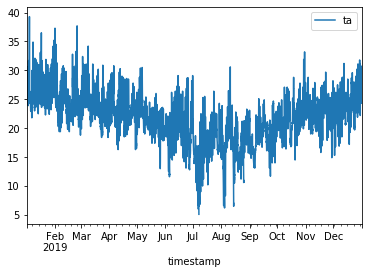

In [2]:
ta_df = pd.read_csv(
    'data/ambient_temperature_hourly.csv',
    header=10,
    date_parser=pd.to_datetime,
    names=['timestamp', 'ta'],
    index_col='timestamp',
)
display(ta_df)
display(ta_df.describe())
ta_df.plot()

Função para plotar multiplos gráficos com eixos diferentes

In [3]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):
    """ https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes """
    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
#     colors = plotting._style._get_standard_colors(num_colors=len(cols))
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

# from random import randrange

# data = pd.DataFrame(dict(
#     s1=[randrange(-1000, 1000) for _ in range(100)],
#     s2=[randrange(-100, 100) for _ in range(100)],
#     s3=[randrange(-10, 10) for _ in range(100)],
# ))

# plot_multi(data.cumsum(), figsize=(10, 5))

# Gerando os dados do sensor

,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037799,108.276400,37.798651,220.056107,0.171774,5.403371
std,4.298974,0.009281,57.311028,9.280510,1.439526,0.042184,1.628979
min,5.100000,0.007499,0.034225,7.498894,217.512929,0.034079,1.248548
25%,19.200000,0.031373,61.204506,31.373242,218.810616,0.142507,4.083121
50%,21.900000,0.037339,112.525607,37.339144,220.047193,0.169634,5.642353
75%,24.600000,0.043754,154.451478,43.753923,221.311475,0.198851,6.552133
max,39.300000,0.080015,209.211679,80.014728,222.594310,0.363984,8.798044


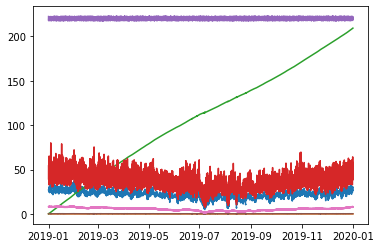

Done: the data for the sensor id 0 was saved to: data/0_sensor_0_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.039269,112.557822,39.268614,220.056023,0.178460,5.403375
std,4.298974,0.009607,59.642331,9.607158,1.439291,0.043690,1.626998
min,5.100000,0.010035,0.031669,10.035255,217.507837,0.045656,1.238222
25%,19.200000,0.032569,63.478834,32.569376,218.813099,0.147982,4.099133
50%,21.900000,0.038681,116.956045,38.680764,220.049481,0.175711,5.627676
75%,24.600000,0.045587,160.787946,45.586967,221.306562,0.207256,6.556678
max,39.300000,0.080091,217.347776,80.090687,222.585449,0.367099,8.796263


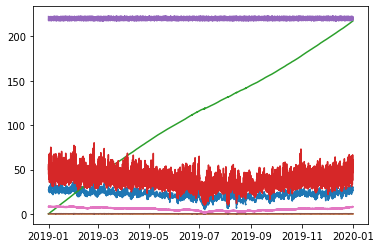

Done: the data for the sensor id 1 was saved to: data/0_sensor_1_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037899,108.608970,37.899285,220.055713,0.172232,5.405260
std,4.298974,0.009276,57.451406,9.275669,1.439245,0.042167,1.626374
min,5.100000,0.009000,0.030682,9.000479,217.518594,0.041362,1.277623
25%,19.200000,0.031495,61.358818,31.494612,218.817792,0.142897,4.118701
50%,21.900000,0.037427,112.880894,37.426760,220.042388,0.170018,5.638928
75%,24.600000,0.043811,154.950666,43.810522,221.311417,0.198949,6.547291
max,39.300000,0.073767,209.768679,73.766685,222.591123,0.338947,8.803293


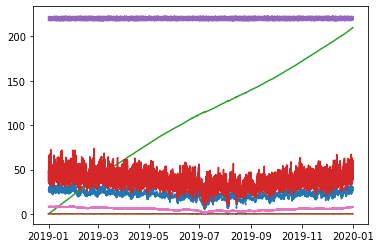

Done: the data for the sensor id 2 was saved to: data/0_sensor_2_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037656,107.960445,37.656355,220.056453,0.171130,5.400054
std,4.298974,0.009242,57.179689,9.242425,1.439766,0.042026,1.634882
min,5.100000,0.007379,0.029999,7.378759,217.510189,0.033916,1.231811
25%,19.200000,0.031170,60.854987,31.169599,218.818352,0.141781,4.080958
50%,21.900000,0.037054,112.175537,37.054485,220.043587,0.168479,5.621716
75%,24.600000,0.043512,154.192217,43.512178,221.314200,0.197678,6.557209
max,39.300000,0.079545,208.424089,79.544588,222.590420,0.361391,8.751027


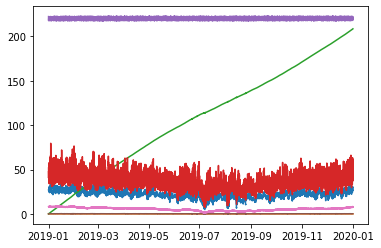

Done: the data for the sensor id 3 was saved to: data/0_sensor_3_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.038527,110.316873,38.526647,220.056475,0.175086,5.402082
std,4.298974,0.009453,58.452823,9.453365,1.439252,0.042984,1.629326
min,5.100000,0.007349,0.026758,7.349238,217.507583,0.033769,1.238668
25%,19.200000,0.031907,62.159091,31.906762,218.820441,0.145005,4.121883
50%,21.900000,0.038016,114.663679,38.016085,220.048086,0.172844,5.647032
75%,24.600000,0.044764,157.458166,44.764477,221.308646,0.203555,6.531852
max,39.300000,0.078791,213.241065,78.790949,222.592298,0.358381,8.807566


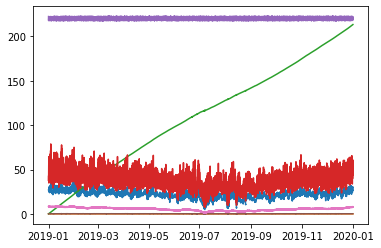

Done: the data for the sensor id 4 was saved to: data/0_sensor_4_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037873,108.601065,37.872739,220.055611,0.172114,5.401526
std,4.298974,0.009273,57.489790,9.272983,1.439114,0.042159,1.628876
min,5.100000,0.008432,0.025143,8.432199,217.508102,0.038745,1.222374
25%,19.200000,0.031400,61.227604,31.400078,218.814198,0.142677,4.093570
50%,21.900000,0.037381,112.895655,37.381056,220.046245,0.169929,5.649035
75%,24.600000,0.043871,155.000249,43.871074,221.316611,0.199380,6.549282
max,39.300000,0.080506,209.621749,80.505975,222.592405,0.366205,8.792506


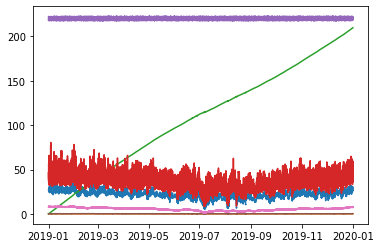

Done: the data for the sensor id 5 was saved to: data/0_sensor_5_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.037831,108.318896,37.830969,220.056014,0.171923,5.402537
std,4.298974,0.009274,57.413223,9.273825,1.439173,0.042168,1.633876
min,5.100000,0.006827,0.028333,6.827055,217.518897,0.031022,1.213630
25%,19.200000,0.031425,61.067658,31.424992,218.818211,0.142589,4.097410
50%,21.900000,0.037332,112.578229,37.331819,220.045313,0.169744,5.632596
75%,24.600000,0.043875,154.702611,43.875250,221.312847,0.199342,6.563667
max,39.300000,0.078926,209.390558,78.925787,222.592095,0.359006,8.791359


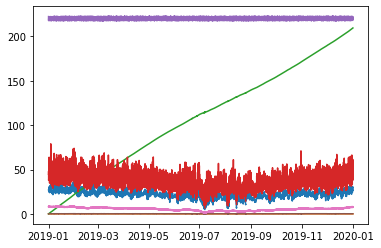

Done: the data for the sensor id 6 was saved to: data/0_sensor_6_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.038779,110.962543,38.778933,220.055754,0.176230,5.399389
std,4.298974,0.009550,58.763754,9.550445,1.439243,0.043419,1.627882
min,5.100000,0.007091,0.024529,7.090906,217.510098,0.032226,1.236371
25%,19.200000,0.032108,62.548620,32.108387,218.817872,0.145835,4.109080
50%,21.900000,0.038214,115.196846,38.214300,220.051437,0.173531,5.645426
75%,24.600000,0.044901,158.307138,44.901224,221.312920,0.204129,6.540031
max,39.300000,0.086880,214.637443,86.879749,222.596112,0.394702,8.808743


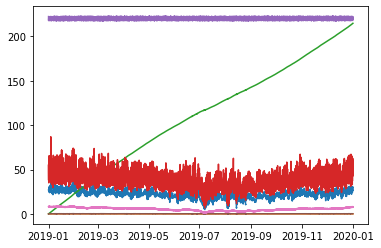

Done: the data for the sensor id 7 was saved to: data/0_sensor_7_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.039075,112.054028,39.074518,220.056215,0.177576,5.400518
std,4.298974,0.009655,59.257010,9.654994,1.439235,0.043906,1.625967
min,5.100000,0.007101,0.023630,7.101223,217.510601,0.032640,1.301757
25%,19.200000,0.032455,63.324592,32.455211,218.803852,0.147522,4.095997
50%,21.900000,0.038442,116.562531,38.442329,220.045385,0.174751,5.642923
75%,24.600000,0.045430,159.840691,45.429518,221.304239,0.206583,6.549259
max,39.300000,0.081520,216.273474,81.520087,222.595596,0.368610,8.807755


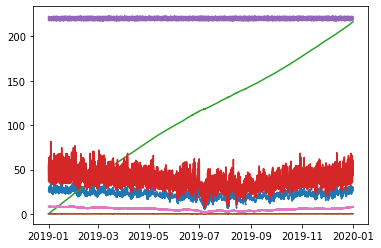

Done: the data for the sensor id 8 was saved to: data/0_sensor_8_db.csv


,ambiente_temperature,energy,cost,active_power,voltage,current,internal_temperature
count,8751.000000,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000
mean,21.815987,0.039155,112.314421,39.155256,220.056279,0.177942,5.404516
std,4.298974,0.009667,59.384411,9.666569,1.439178,0.043950,1.628598
min,5.100000,0.009162,0.028660,9.161942,217.511338,0.042108,1.211887
25%,19.200000,0.032367,63.539366,32.366904,218.807376,0.147041,4.119971
50%,21.900000,0.038569,116.825754,38.569190,220.039833,0.175241,5.634365
75%,24.600000,0.045482,160.190798,45.482344,221.313220,0.206497,6.538081
max,39.300000,0.084440,216.720354,84.440245,222.595622,0.383998,8.798211


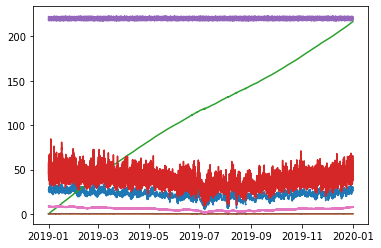

Done: the data for the sensor id 9 was saved to: data/0_sensor_9_db.csv


In [5]:
voltage = 220 + (np.random.rand(len(ta_df)) * 5 - 2.5)
basic_energy_tariff = 0.50599 * (1 + 0.25)  # Tarifa residencial B da celesc + aliquota: 12% se menor que 150kWh, 25% se maior.

def generate_sensor_dataframe(df, sensor: dict, verbose=False, plot=False):
    df['E'] = (0.6 + 0.4*np.random.rand(len(df))) * sensor['E_hourly'] * df['ta'] / df['ta'].mean() / 1000 # kwh
    df['cost'] = df['E'].cumsum() * basic_energy_tariff
    df['P'] = 1000 * df['E'] / 1 # watts
    df['V'] = voltage + 0.1 * np.random.rand(len(df))
    df['I'] = df['P'] / df['V']
    df['ti'] = 4 + np.random.rand(len(df)) + 0.5*df['ta'].rolling(500, win_type='blackman', center=True, min_periods=1).mean() -10
    
    df = df.rename(columns={
        "ta": "ambiente_temperature",
        "ti": "internal_temperature",
        "V": "voltage",
        "I": "current",
        "P": "active_power",
        "E": "energy",
        "cost": "cost",
    })
    if verbose:
        display(df.describe())
    if plot:
        plt.Figure(figsize=(20, 10))
        plt.plot(df.rolling(1, win_type='blackman', center=True, min_periods=1).mean())
#         plot_multi(df.rolling(25, win_type='blackman', center=True, min_periods=1).mean())
        plt.show()
    
    output_filename = f"data/0_sensor_{int(sensor['sensor_id'])}_db.csv"
    df.to_csv(output_filename)
    print(f"Done: the data for the sensor id {sensor['sensor_id']} was saved to: {output_filename}")
    del df


for sensor_id in [0,1,2,3,4,5,6,7,8,9]:
    sensor = generate_freezer_unit(sensor_id)
    generate_sensor_dataframe(ta_df.copy(), sensor, verbose=True, plot=True)